# <center>FASHION - Multiclass Classification With CNN<br/> (using Keras)</center>


In this notebook, we will illustrate multi-class classification for the **Fashion-MNIST dataset** using Convolution Neural Networks (CNN). Fashion-MNIST can be used as drop-in replacement for the original MNIST dataset (of 10 categories of handwritten digits). It shares the same image size (28x28 graysacle) and has 60,000 training and 10,000 testing splits.

We have 10 categories of output labels - unlike the MNIST dataset, where they were values for numbers, we have distinct types here.

Label Description
* 0 - T-shirt/top
* 1 - Trouser
* 2 - Pullover
* 3 - Dress
* 4 - Coat
* 5 - Sandal
* 6 - Shirt
* 7 - Sneaker
* 8 - Bag
* 9 - Ankle boot

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import os, random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

float_formatter = lambda x: '%.4f' % x
np.set_printoptions(formatter={'float_kind':float_formatter})
np.set_printoptions(threshold=np.inf, suppress=True, precision=4)

plt.style.use("seaborn-colorblind")
plt.rcParams["figure.figsize"] = (8, 6)
sns.set_style("darkgrid")
sns.set_context(context='notebook', font_scale=1.25)
sns.set_style({"font.sans-serif": ["Verdana", "Arial", "Calibri", "DejaVu Sans"]})


seed = 41
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

## Loading & Preprocessing the Dataset
Loading the Fashion-MNSIT dataset from 'keras.datasets' library and call 'keras.datasets.fashion_mnist.load_data()'.



In [ ]:
def load_and_preprocess_data(std_normalize=False, debug=False):
    from tensorflow.keras.datasets.fashion_mnist import load_data
    from tensorflow.keras.utils import to_categorical

    (X_train, y_train), (X_test, y_test) = load_data()

    if debug:
        print('Before preprocessing:')
        print(' - X_train.shape = {}, y_train.shape = {}'.format(X_train.shape, y_train.shape))
        print(' - X_test.shape = {}, y_test.shape = {}'.format(X_test.shape, y_test.shape))

    indexes = np.arange(X_test.shape[0])
    indexes = np.random.permutation(indexes)
    X_test = X_test[indexes]
    y_test = y_test[indexes]

    indexes = np.arange(X_train.shape[0])
    indexes = np.random.permutation(indexes)
    X_train = X_train[indexes]
    y_train = y_train[indexes]


    val_count = 8000
    X_val = X_test[:val_count]
    y_val = y_test[:val_count]
    X_test = X_test[val_count:]
    y_test = y_test[val_count:]


    test_images, test_labels = X_test.copy(), y_test.copy()

    if std_normalize:
        epsilon = 1e-7
        X_train_mean = np.mean(X_train, axis=(0,1,2,3))
        X_train_std = np.std(X_train, axis=(0,1,2,3))
        X_train = (X_train - X_train_mean) / (X_train_std + epsilon)
        X_val = (X_val - X_train_mean) / (X_train_std + epsilon)
        X_test = (X_test - X_train_mean) / (X_train_std + epsilon)
    else:
        X_train = X_train.astype('float32') / 255.0
        X_val = X_val.astype('float32') / 255.0
        X_test = X_test.astype('float32') / 255.0

    y_train = to_categorical(y_train, 10)
    y_val = to_categorical(y_val, 10)
    y_test = to_categorical(y_test, 10)

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
    X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], X_val.shape[2], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))

    if debug:
        print('After preprocessing:')
        print(' - X_train.shape = {}, y_train.shape = {}'.format(X_train.shape, y_train.shape))
        print(' - X_val.shape = {}, y_val.shape = {}'.format(X_val.shape, y_val.shape))
        print(' - X_test.shape = {}, y_test.shape = {}'.format(X_test.shape, y_test.shape))
        print(' - test_images.shape = {}, test_labels.shape = {}'.format(test_images.shape,
            test_labels.shape))

    return (X_train, y_train), (X_val, y_val), (X_test, y_test), (test_images, test_labels)

In [ ]:
def display_sample(sample_images, sample_labels, sample_predictions=None, num_rows=5, num_cols=10,
                   plot_title=None, fig_size=None):
    assert sample_images.shape[0] == num_rows * num_cols
    FASHION_LABELS = {
        0: 'T-shirt/top',
        1: 'Trouser',
        2: 'Pullover',
        3: 'Dress',
        4: 'Coat',
        5: 'Sandal',
        6: 'Shirt',
        7: 'Sneaker',
        8: 'Bag',
        9: 'Ankle boot',
    }

    with sns.axes_style("whitegrid"):
        sns.set_context("notebook", font_scale=1.1)
        sns.set_style({"font.sans-serif": ["Verdana", "Arial", "Calibri", "DejaVu Sans"]})

        f, ax = plt.subplots(num_rows, num_cols, figsize=((14, 9) if fig_size is None else fig_size),
            gridspec_kw={"wspace": 0.02, "hspace": 0.30}, squeeze=True)

        for r in range(num_rows):
            for c in range(num_cols):
                image_index = r * num_cols + c
                ax[r, c].axis("off")
                ax[r, c].imshow(sample_images[image_index], cmap="Greys")

                if sample_predictions is None:
                    title = ax[r, c].set_title("%s" % FASHION_LABELS[sample_labels[image_index]])
                else:
                    true_label = sample_labels[image_index]
                    pred_label = sample_predictions[image_index]
                    prediction_matches_true = (sample_labels[image_index] == sample_predictions[image_index])
                    if prediction_matches_true:
                        title = FASHION_LABELS[true_label]
                        title_color = 'g'
                    else:
                        title = '%s/%s' % (FASHION_LABELS[true_label], FASHION_LABELS[pred_label])
                        title_color = 'r'
                    title = ax[r, c].set_title(title)
                    plt.setp(title, color=title_color)
        if plot_title is not None:
            f.suptitle(plot_title)

        plt.show()
        plt.close()

In [ ]:
# load & pre-process our dataset
(X_train, y_train), (X_val, y_val), (X_test, y_test), (test_images, test_labels) = \
    load_and_preprocess_data(debug=True)

4422102/4422102 [==============================] - 0s 0us/step
Before preprocessing:
 - X_train.shape = (60000, 28, 28), y_train.shape = (60000,)
 - X_test.shape = (10000, 28, 28), y_test.shape = (10000,)
After preprocessing:
 - X_train.shape = (60000, 28, 28, 1), y_train.shape = (60000, 10)
 - X_val.shape = (8000, 28, 28, 1), y_val.shape = (8000, 10)
 - X_test.shape = (2000, 28, 28, 1), y_test.shape = (2000, 10)
 - test_images.shape = (2000, 28, 28), test_labels.shape = (2000,)


Notice the following:
* **Before Pre-processing**:
    * We have 60,000 images in the training set & 10,000 images in the test set.
    * They have shapes of `(60000,28,28)` and `(10000,28,28)` respectively.
* **After pre-processing**:
    * The training dataset retains it's 60,000 images
    * The test dataset has been split into a cross-validation dataset (X_val/y_val) with 6,000 records and a test set (X_test/y_test) with 4,000 record
    * We have reshaped all the feature (X's) datasets into 3D tensors
    * We have one-hot encoded all the label datasets to 10 classes

Let us randomly select 50 images from the test dataset and see how they look - we will display the images in a 5x10 grid below.

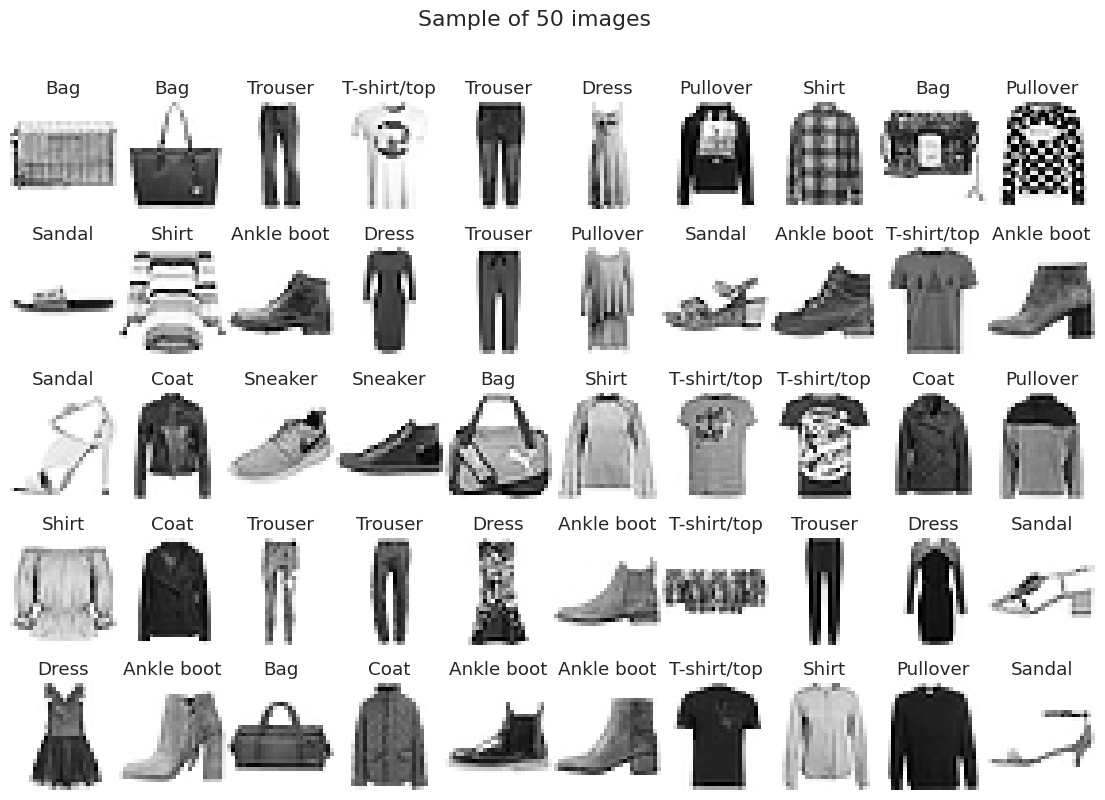

In [ ]:
sample_size = 50
rand_indexes = np.random.randint(0, len(X_test), sample_size)
sample_images = test_images[rand_indexes]
sample_labels = test_labels[rand_indexes]
display_sample(sample_images, sample_labels, plot_title='Sample of %d images' % sample_size)

## Keras Model Development

This section includes the following functions:
* `train_and_evaluate_model()` - trains model on training dataset & evaluates performance on the cross-validation dataset. Saves model to a file name on disk (Google Drive if running in Colab or directory on disk)
* `do_predictions()` - loads model state from disk and tests it on test dataset and plots predictions on a random sample of non-preprocessed data from the test set.

In [ ]:
import tensorflow.keras.backend as K
from tensorflow.keras.layers import (Input, Dense, Dropout, Conv2D, MaxPooling2D, Activation,
                                     BatchNormalization, Flatten)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

import kr_helper_funcs as kru

K.clear_session()   # start afresh each time!!

In [ ]:
# some globals
IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS, NUM_CLASSES = 28, 28, 1, 10

In [ ]:
# cross-train model & evaluate performance on train & cross-validation data
def train_and_evaluate_model(model, X_train, y_train, X_val, y_val,
                             num_epochs=25, batch_size=32, plot_metric='acc', plot_title=None,
                             model_save_name=None, callbacks=None, use_data_aug=False):
    """
    cross train & evaluate model's performance on training, cross-val & test datasets
        @params:
            - X_train/y_train: pre-processed training datasets
            - X_val/y_val: pre-processed cross-validation datasets
            - epochs (optional, default=25) - no of epochs for which training should be done
            - batch_size (optional, default=32) - the batch size to use for mini-batch gradient descent training
            - plot_title (optional, default=None) - plots loss vs epochs and accuracy vs epoch curves if assigned value
                other than None. Uses this assigned value as the plot's title
            - model_save_name (optional, default=None) - the file name to which the Keras model is saved to - if value
                other than None is specified, then the Keras model's state is saved to this file name (NOTE: this is saved
                in the './keras_models/model_save_name' file)
            - callbacks (optional, default=None) a list of callbacks to apply during training
            - use_data_aug (optional, default=False) - if true, use data augmentation to generate additional training images
    """
    # we will add the following callbacks by default. If user provides callbacks, then
    # we will use those INSTEAD of these
    callbacks_list_default = [
        # reduce learning rate by a factor of 5 (i.e. lr/=5.0)
        # if val_loss does not reduce for 3 epochs
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=3
        ),
        # Stop training if val_acc does not improve for
        # 5 or more epochs
        EarlyStopping(
            monitor='val_acc',
            patience=5
        )
    ]

    # if user provides her own callbacks, use them instead of our list
    callbacks2use = (callbacks_list_default if callbacks is None else callbacks)

    if use_data_aug:
        print('Training mode with data augmentation...', flush=True)
        # use image augmentation to increase training images

        from keras.preprocessing.image import ImageDataGenerator

        # NOTE: our datasets have already been scaled
        train_datagen = ImageDataGenerator(
            rotation_range=10,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.3,
            zoom_range=(0.9, 1.1),
            horizontal_flip=False,
            vertical_flip=False,
            fill_mode='constant',
            cval=0)

        #train_datagen.fit(X_train)

        # fit the data generator on training data & validate on
        num_batches = len(X_train) // batch_size
        num_batches += (0 if len(X_train) % batch_size == 0 else 1)

        history = model.fit_generator(train_datagen.flow(X_train, y_train,
                                                         batch_size=batch_size),
                                      steps_per_epoch = num_batches,
                                      epochs = num_epochs,
                                      callbacks = callbacks2use,
                                      validation_data = (X_val, y_val))
    else:
        # train on X_train/y_train & cross-validate on X_val/y_val
        history = model.fit(X_train, y_train, epochs=num_epochs,
                            batch_size = batch_size, validation_data = (X_val, y_val),
                            callbacks = callbacks2use)


    if plot_title is not None:
        kru.show_plots(history.history, metric=plot_metric, plot_title=plot_title)

    # evaluate metrics
    print("\nEvaluating...", flush=True)
    print('Training data:', flush=True)
    loss, acc = model.evaluate(X_train, y_train, verbose=1)
    print("  Training : loss %.3f - acc %.3f" % (loss, acc))

    print('Cross-validation data:', flush=True)
    loss, acc = model.evaluate(X_val, y_val, verbose=1)
    print("  Cross-val: loss %.3f - acc %.3f" % (loss, acc))

    if model_save_name is not None:
        kru.save_model(model, model_save_name, MODEL_SAVE_DIR)

In [ ]:
def do_predictions(model_save_name, X_test, y_test, test_images, test_labels, plot_title=None):
    def test_model(model, X_test, y_test, test_images, test_labels, plot_title=None):
        print('Evaluating against test data...', flush=True)
        loss, acc = model.evaluate(X_test, y_test)
        print('  - Test data: loss %.3f - acc %.3f' % (loss, acc))

        print('Displaying sample predictions...', flush=True)
        # run predictions
        y_pred = model.predict(X_test)

        # test with 50 random images
        num_images = 50
        rand_indexes = np.random.randint(0, len(X_test), num_images)
        sample_images = test_images[rand_indexes]
        sample_labels = test_labels[rand_indexes]
        sample_predictions = np.argmax(y_pred[rand_indexes], axis=1)

        display_sample(sample_images, sample_labels, sample_predictions,
            num_rows=5, num_cols=10, plot_title=plot_title)

    # load the model from saved state
    model = kru.load_model(model_save_name, MODEL_SAVE_DIR)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    test_model(model, X_test, y_test, test_images, test_labels, plot_title=plot_title)
    del model

# Model Development

In this section, we cross-train various configurations of the model on `(X_train, y_train)` and `(X_val, y_val)` and record the performance. The model we will use is created in the `build_model()` function below. The following _configurations_ are trained and evaluated:
>Configuration|
>:---|
>**Base Model** (no regularization)|
>**Base Model + L2 Regularization**|
>**Base Model + Dropout Regularization**|
>**Base Model + L2 Regularization + Dropout Regularization**|


In [ ]:
def build_model(use_l2_reg=False, use_dropout=False, lr=0.0001,
                l2_loss_lambda=0.0015):
    K.clear_session()

    assert l2_loss_lambda is not None

    l2 = regularizers.l2(l2_loss_lambda) if use_l2_reg else None
    if l2 is not None: print('Using L2 regularization %.6f' % l2_loss_lambda)

    inputs = Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS))

    x = Conv2D(32, kernel_size=(3, 3), padding='same', kernel_regularizer=l2)(inputs)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    if use_dropout: x = Dropout(0.15)(x)

    x = Conv2D(64, kernel_size=(3, 3), padding='same', kernel_regularizer=l2)(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    if use_dropout: x = Dropout(0.2)(x)

    x = Conv2D(128, kernel_size=(3, 3), padding='same', kernel_regularizer=l2)(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    if use_dropout: x = Dropout(0.3)(x)

    x = Flatten()(x)
    if use_dropout: x = Dropout(0.4)(x)

    x = Dense(1024, activation='relu', kernel_regularizer=l2)(x)
    if use_dropout: x = Dropout(0.4)(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2)(x)
    if use_dropout: x = Dropout(0.2)(x)

    out = Dense(units=NUM_CLASSES, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=out)
    adam = Adam(lr=lr) #, decay=1e-6)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['acc'])

    return model

In [ ]:
def plot_model(model, file_name):
    from keras.utils import plot_model
    from IPython.display import Image, display

    try:
        image_path = os.path.join(MODEL_SAVE_DIR, file_name + '.png')
        plot_model(model, show_shapes=True, show_layer_names=True, to_file=image_path)
        display(Image(image_path))
    except:
        print('Warning! Can\'t display model structure graphically. Displaying summary instead')
        print(model.summary())

## Training Base Model

Training model without any regularization - no Batch Normalization, no L2 regularization and no Dropout regularization

In [ ]:
callbacks_list2 = [
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=4,
        min_lr=0.00000001
    ),
]

In [ ]:
model = build_model()
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 activation (Activation)     (None, 28, 28, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496 

Epoch 1/50
938/938 [==============================] - 18s 7ms/step - loss: 0.3746 - acc: 0.8644 - val_loss: 0.2958 - val_acc: 0.8920 - lr: 0.0010
Epoch 2/50
938/938 [==============================] - 6s 6ms/step - loss: 0.2456 - acc: 0.9086 - val_loss: 0.2862 - val_acc: 0.8975 - lr: 0.0010
Epoch 3/50
938/938 [==============================] - 7s 7ms/step - loss: 0.2070 - acc: 0.9235 - val_loss: 0.2603 - val_acc: 0.9041 - lr: 0.0010
Epoch 4/50
938/938 [==============================] - 6s 6ms/step - loss: 0.1779 - acc: 0.9335 - val_loss: 0.3084 - val_acc: 0.8892 - lr: 0.0010
Epoch 5/50
938/938 [==============================] - 7s 7ms/step - loss: 0.1572 - acc: 0.9415 - val_loss: 0.2559 - val_acc: 0.9100 - lr: 0.0010
Epoch 6/50
938/938 [==============================] - 6s 7ms/step - loss: 0.1385 - acc: 0.9487 - val_loss: 0.2445 - val_acc: 0.9107 - lr: 0.0010
Epoch 7/50
938/938 [==============================] - 10s 11ms/step - loss: 0.1201 - acc: 0.9554 - val_loss: 0.2931 - val_acc: 0.

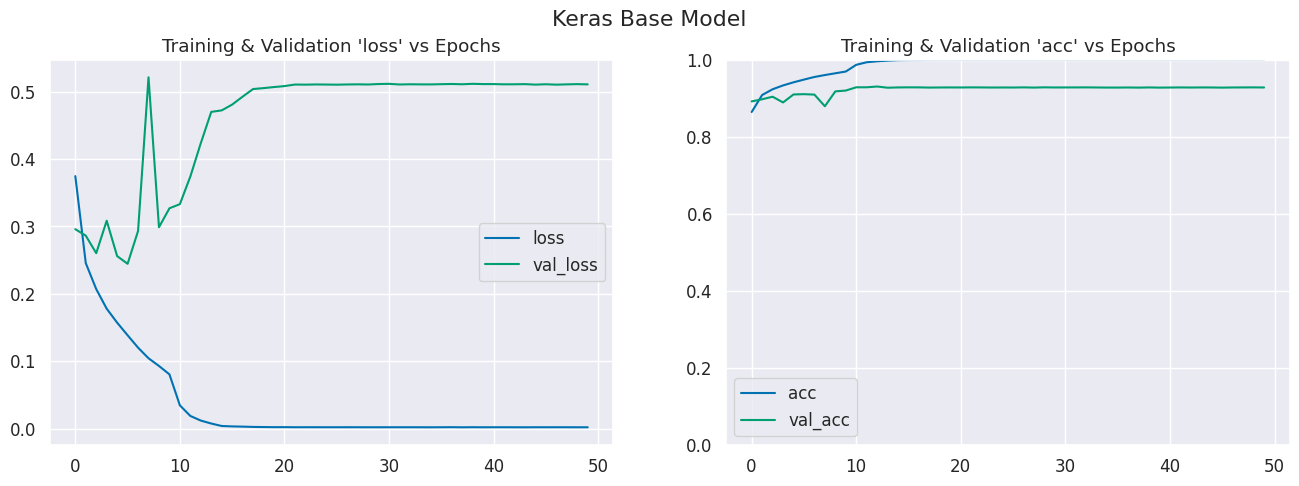


Evaluating...
Training data:
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0017 - acc: 0.9998
  Training : loss 0.002 - acc 1.000
Cross-validation data:
250/250 [==============================] - 1s 3ms/step - loss: 0.5107 - acc: 0.9281
  Cross-val: loss 0.511 - acc 0.928
Saved model to file /content/drive/My Drive/Colab Notebooks/model_states/kr_fashion_cnn_base.h5


In [ ]:
model_name = 'kr_fashion_cnn_base'
plot_title = 'Keras Base Model'
train_and_evaluate_model(model, X_train, y_train, X_val, y_val,
                         num_epochs=50, batch_size=64, callbacks=callbacks_list2,
                         plot_title=plot_title, model_save_name=model_name)
del model

Loaded Keras model from /content/drive/My Drive/Colab Notebooks/model_states/kr_fashion_cnn_base.h5
Evaluating against test data...
63/63 [==============================] - 1s 5ms/step - loss: 0.4851 - accuracy: 0.9365
  - Test data: loss 0.485 - acc 0.937
Displaying sample predictions...
63/63 [==============================] - 0s 2ms/step


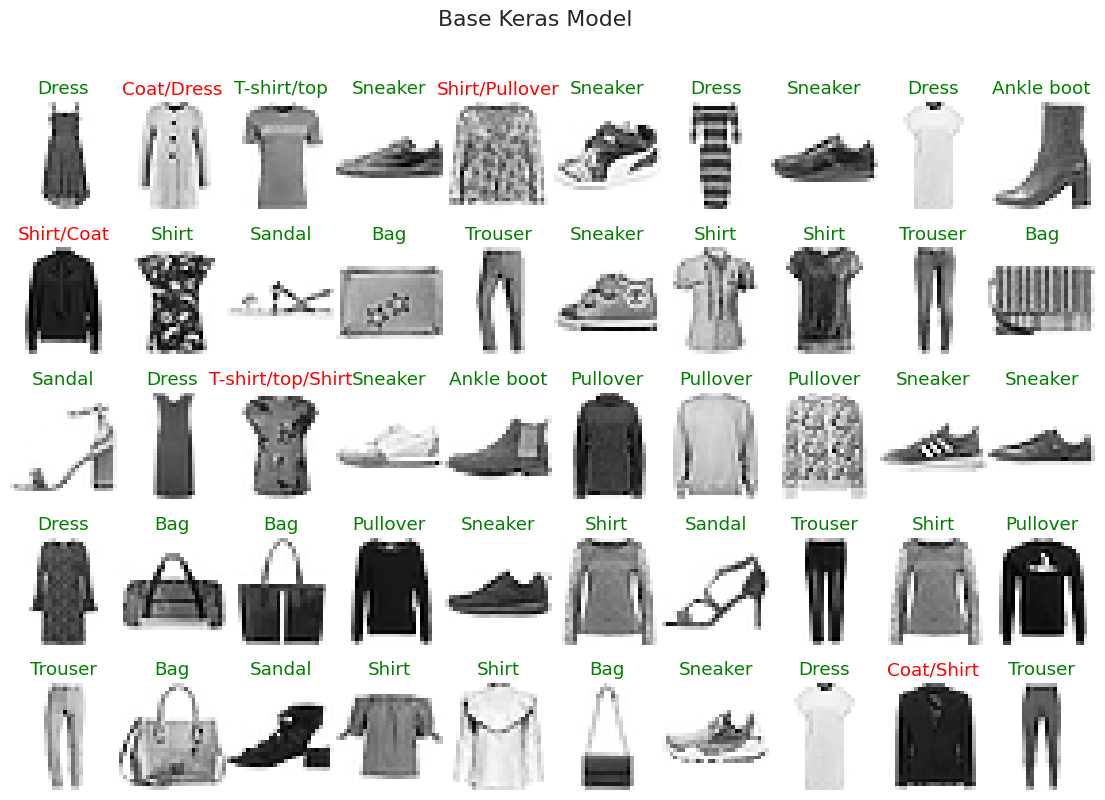

In [ ]:
do_predictions('kr_fashion_cnn_base', X_test, y_test, test_images, test_labels, plot_title='Base Keras Model')

In [ ]:
model = build_model(use_l2_reg=True)
print(model.summary())

Using L2 regularization 0.001500
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 activation (Activation)     (None, 28, 28, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)          

Epoch 1/100
1875/1875 [==============================] - 16s 6ms/step - loss: 1.0231 - acc: 0.8593 - val_loss: 0.5174 - val_acc: 0.8826 - lr: 0.0010
Epoch 2/100
1875/1875 [==============================] - 11s 6ms/step - loss: 0.4621 - acc: 0.8934 - val_loss: 0.5442 - val_acc: 0.8445 - lr: 0.0010
Epoch 3/100
1875/1875 [==============================] - 11s 6ms/step - loss: 0.4167 - acc: 0.9024 - val_loss: 0.4504 - val_acc: 0.8865 - lr: 0.0010
Epoch 4/100
1875/1875 [==============================] - 11s 6ms/step - loss: 0.3897 - acc: 0.9072 - val_loss: 0.4299 - val_acc: 0.8917 - lr: 0.0010
Epoch 5/100
1875/1875 [==============================] - 11s 6ms/step - loss: 0.3730 - acc: 0.9097 - val_loss: 0.4059 - val_acc: 0.8936 - lr: 0.0010
Epoch 6/100
1875/1875 [==============================] - 11s 6ms/step - loss: 0.3536 - acc: 0.9128 - val_loss: 0.3965 - val_acc: 0.8986 - lr: 0.0010
Epoch 7/100
1875/1875 [==============================] - 11s 6ms/step - loss: 0.3418 - acc: 0.9160 - val_l

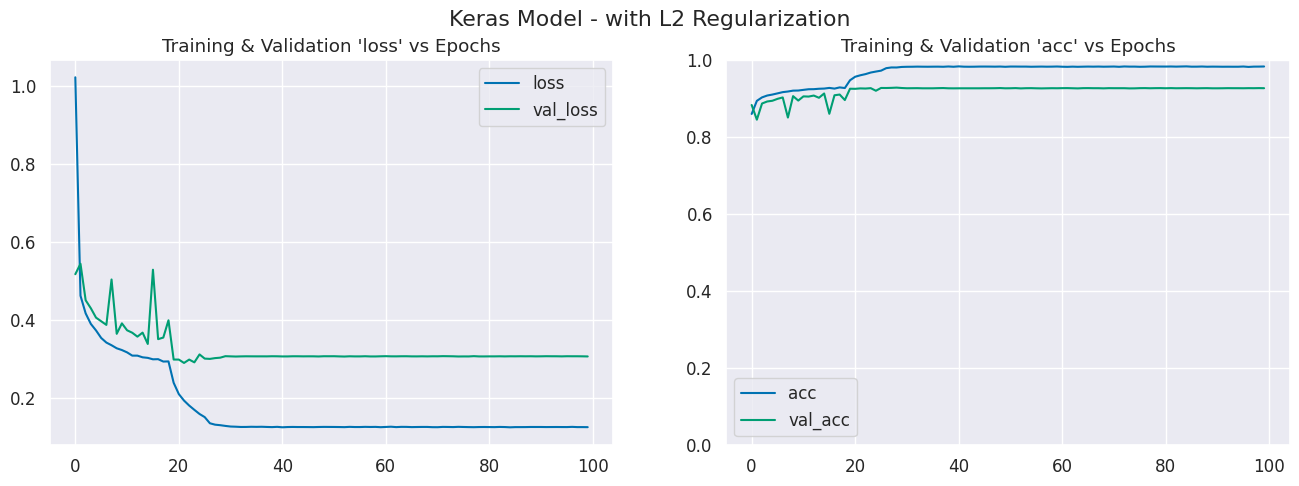


Evaluating...
Training data:
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1208 - acc: 0.9845
  Training : loss 0.121 - acc 0.984
Cross-validation data:
250/250 [==============================] - 1s 4ms/step - loss: 0.3062 - acc: 0.9262
  Cross-val: loss 0.306 - acc 0.926
Saved model to file /content/drive/My Drive/Colab Notebooks/model_states/kr_fashion_cnn_l2_reg_2.h5


In [ ]:
model_name = 'kr_fashion_cnn_l2_reg_2'
plot_title = 'Keras Model - with L2 Regularization'
train_and_evaluate_model(model, X_train, y_train, X_val, y_val,
                         num_epochs=100, batch_size=32,  callbacks=callbacks_list2,
                         plot_title=plot_title, model_save_name=model_name)
del model

Loaded Keras model from /content/drive/My Drive/Colab Notebooks/model_states/kr_fashion_cnn_l2_reg_2.h5
Evaluating against test data...
63/63 [==============================] - 1s 3ms/step - loss: 0.2842 - accuracy: 0.9375
  - Test data: loss 0.284 - acc 0.938
Displaying sample predictions...
63/63 [==============================] - 0s 2ms/step


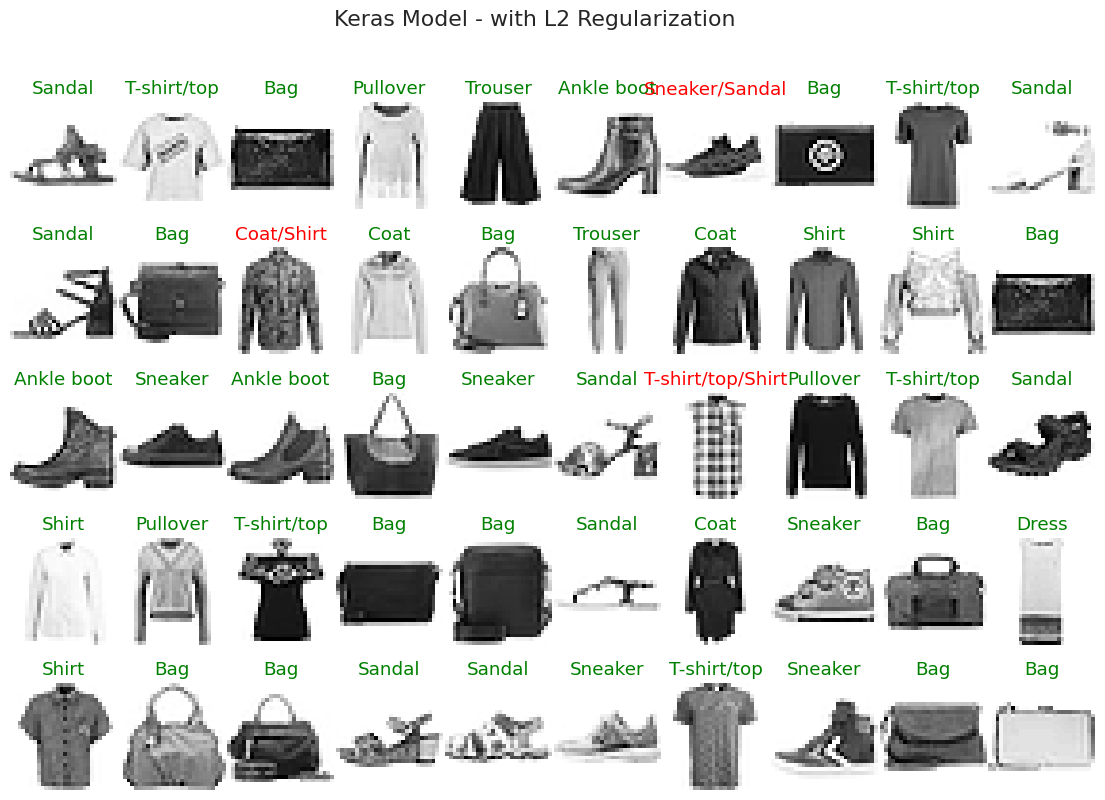

In [ ]:
do_predictions('kr_fashion_cnn_l2_reg_2', X_test, y_test, test_images, test_labels,
               plot_title='Keras Model - with L2 Regularization')

**Observations - model with L2 Regularization:**<br/>


* Adding L2 regularization had significantly reduced overfitting - training accuracy has come down to 95-96% from 99-100% levels of base model.
* Cross-validation and test accuracies are at the same values as the base model - 92-93%.
* From the plots you see that overfitting is delayed by many more epochs - the cross-val loss & accuracy plots follow the training plots for many more epochs before digressing.


In [ ]:
model = build_model(use_dropout=True)
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 activation (Activation)     (None, 28, 28, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0     

Epoch 1/100
1875/1875 [==============================] - 16s 6ms/step - loss: 0.5960 - acc: 0.7887 - val_loss: 0.3961 - val_acc: 0.8605 - lr: 0.0010
Epoch 2/100
1875/1875 [==============================] - 12s 6ms/step - loss: 0.4034 - acc: 0.8519 - val_loss: 0.4175 - val_acc: 0.8570 - lr: 0.0010
Epoch 3/100
1875/1875 [==============================] - 12s 6ms/step - loss: 0.3696 - acc: 0.8675 - val_loss: 0.3704 - val_acc: 0.8692 - lr: 0.0010
Epoch 4/100
1875/1875 [==============================] - 12s 6ms/step - loss: 0.3441 - acc: 0.8764 - val_loss: 0.3165 - val_acc: 0.8884 - lr: 0.0010
Epoch 5/100
1875/1875 [==============================] - 12s 6ms/step - loss: 0.3326 - acc: 0.8801 - val_loss: 0.2881 - val_acc: 0.8963 - lr: 0.0010
Epoch 6/100
1875/1875 [==============================] - 11s 6ms/step - loss: 0.3142 - acc: 0.8876 - val_loss: 0.2584 - val_acc: 0.9068 - lr: 0.0010
Epoch 7/100
1875/1875 [==============================] - 11s 6ms/step - loss: 0.3084 - acc: 0.8904 - val_l

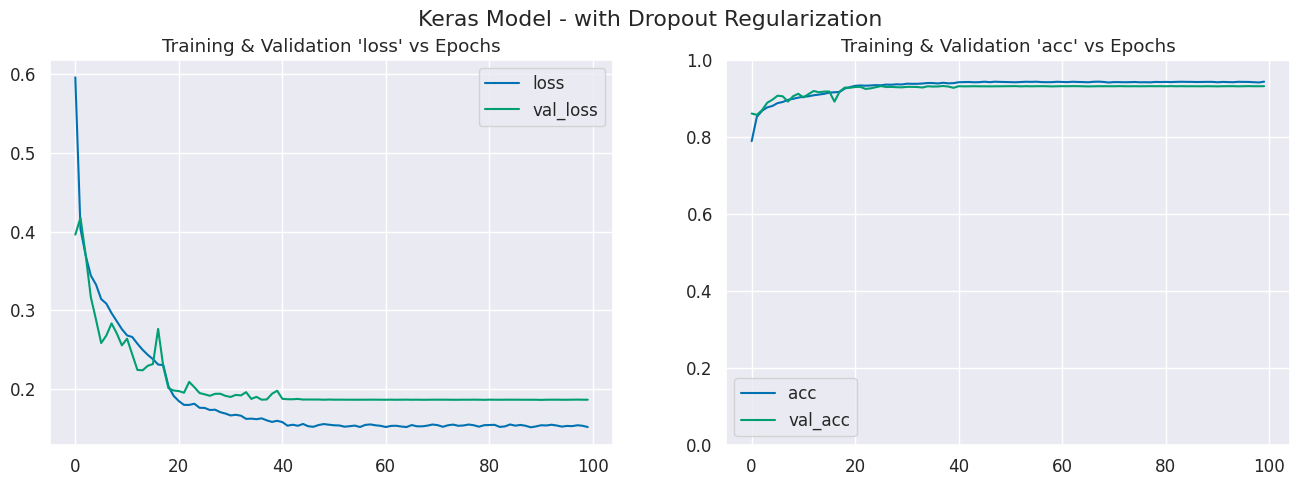


Evaluating...
Training data:
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1029 - acc: 0.9618
  Training : loss 0.103 - acc 0.962
Cross-validation data:
250/250 [==============================] - 1s 3ms/step - loss: 0.1864 - acc: 0.9315
  Cross-val: loss 0.186 - acc 0.932
Saved model to file /content/drive/My Drive/Colab Notebooks/model_states/kr_fashion_cnn_do_reg_2.h5


In [ ]:
model_name = 'kr_fashion_cnn_do_reg_2'
plot_title = 'Keras Model - with Dropout Regularization'
train_and_evaluate_model(model, X_train, y_train, X_val, y_val,
                         num_epochs=100, batch_size=32,  callbacks=callbacks_list2,
                         plot_title=plot_title, model_save_name=model_name)
del model

Loaded Keras model from /content/drive/My Drive/Colab Notebooks/model_states/kr_fashion_cnn_do_reg_2.h5
Evaluating against test data...
63/63 [==============================] - 1s 3ms/step - loss: 0.1764 - accuracy: 0.9390
  - Test data: loss 0.176 - acc 0.939
Displaying sample predictions...
63/63 [==============================] - 0s 2ms/step


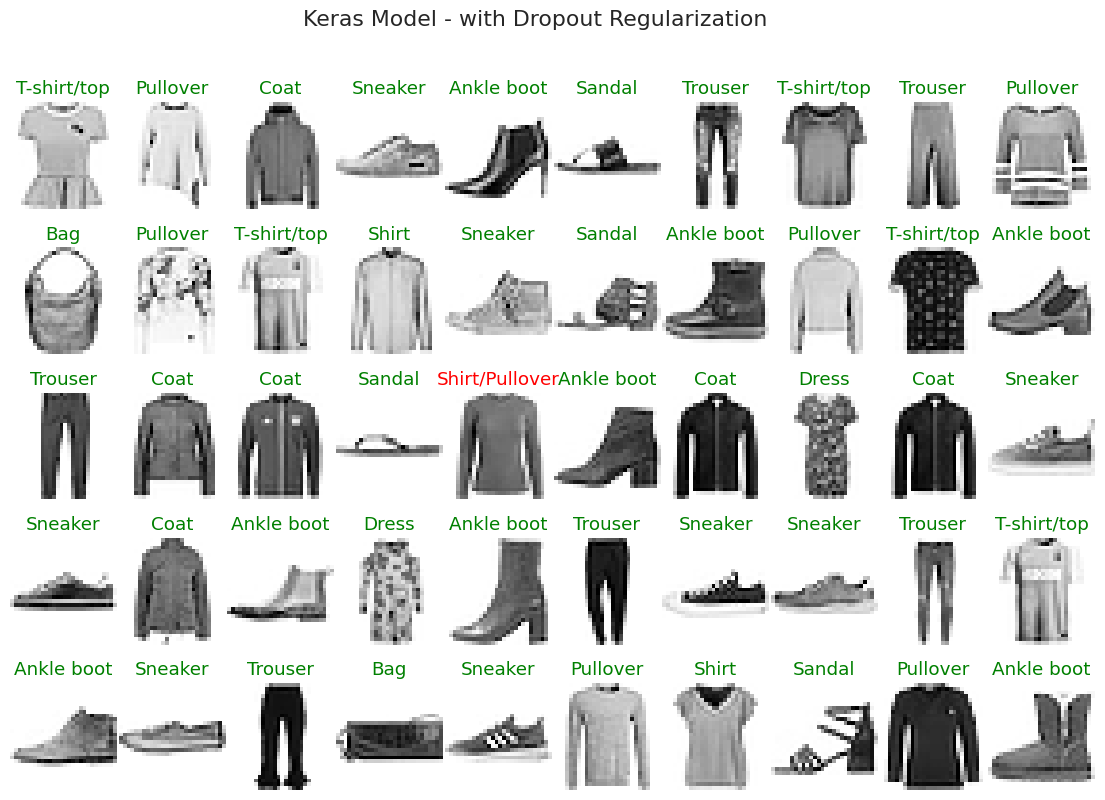

In [ ]:
do_predictions('kr_fashion_cnn_do_reg_2', X_test, y_test, test_images, test_labels,
               plot_title='Keras Model - with Dropout Regularization')

**Observation - model with Dropout Regularization:**<br/>


* As with L2 regularization, adding dropout regularization had  reduced overfitting - training accuracy has come down to 96-97% from 99-100% levels observed with the base model (this is slightly more than with L2 regularization)
* Cross-validation & test accuracy is slightly better than that of the base model & model with L2 Regularization.
* From the plots you see that overfitting is delayed by many more epochs - the cross-val loss & accuracy plots follow the training plots for many more epochs.
* It is difficult to say which model - one with L2 regularization or one with Batch normalization is the better of the two. Just based on test-accuracy, I would pick the one with Dropout Regularization.


## Using both L2 Regularization and Dropout Regularization together
Let's enable both and see if we get better performance (i.e. lesser overfitting & equal-to-cross-validation-or-better test accuracy).<br/>


In [ ]:
model = build_model(use_l2_reg=True, use_dropout=True)
print(model.summary())

Using L2 regularization 0.001500


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 activation (Activation)     (None, 28, 28, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0     

Epoch 1/200
1875/1875 [==============================] - 16s 7ms/step - loss: 1.9170 - acc: 0.7934 - val_loss: 0.9181 - val_acc: 0.8511 - lr: 0.0010
Epoch 2/200
1875/1875 [==============================] - 13s 7ms/step - loss: 0.8615 - acc: 0.8493 - val_loss: 0.7722 - val_acc: 0.8677 - lr: 0.0010
Epoch 3/200
1875/1875 [==============================] - 12s 6ms/step - loss: 0.7929 - acc: 0.8576 - val_loss: 0.7406 - val_acc: 0.8751 - lr: 0.0010
Epoch 4/200
1875/1875 [==============================] - 12s 6ms/step - loss: 0.7632 - acc: 0.8639 - val_loss: 0.6845 - val_acc: 0.8885 - lr: 0.0010
Epoch 5/200
1875/1875 [==============================] - 12s 7ms/step - loss: 0.7497 - acc: 0.8665 - val_loss: 0.6940 - val_acc: 0.8804 - lr: 0.0010
Epoch 6/200
1875/1875 [==============================] - 12s 7ms/step - loss: 0.7257 - acc: 0.8716 - val_loss: 0.6514 - val_acc: 0.8906 - lr: 0.0010
Epoch 7/200
1875/1875 [==============================] - 12s 7ms/step - loss: 0.7119 - acc: 0.8721 - val_l

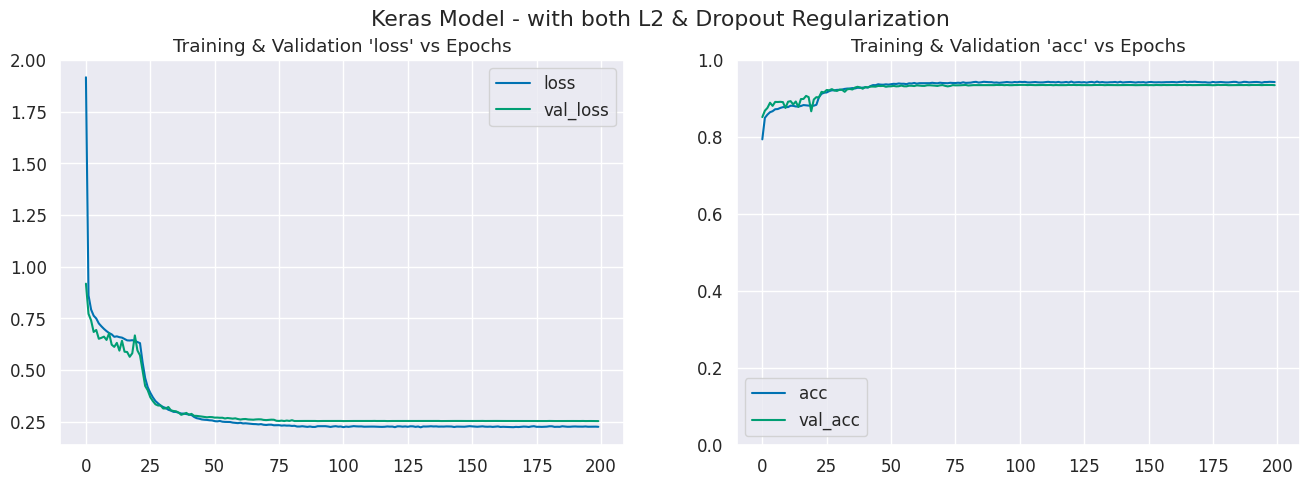


Evaluating...
Training data:
1875/1875 [==============================] - 7s 3ms/step - loss: 0.1685 - acc: 0.9634
  Training : loss 0.168 - acc 0.963
Cross-validation data:
250/250 [==============================] - 1s 3ms/step - loss: 0.2531 - acc: 0.9341
  Cross-val: loss 0.253 - acc 0.934
Saved model to file /content/drive/My Drive/Colab Notebooks/model_states/kr_fashion_cnn_do_l2_reg_2.h5


In [ ]:
model_name = 'kr_fashion_cnn_do_l2_reg_2'
plot_title = 'Keras Model - with both L2 & Dropout Regularization'
train_and_evaluate_model(model, X_train, y_train, X_val, y_val,
                         num_epochs=200, batch_size=32, callbacks=callbacks_list2,
                         plot_title=plot_title, model_save_name=model_name)
del model # we will load model from saved state to make predictions (as shown in next cell)

Loaded Keras model from /content/drive/My Drive/Colab Notebooks/model_states/kr_fashion_cnn_do_l2_reg_2.h5
Evaluating against test data...
63/63 [==============================] - 1s 4ms/step - loss: 0.2509 - accuracy: 0.9345
  - Test data: loss 0.251 - acc 0.934
Displaying sample predictions...
63/63 [==============================] - 0s 2ms/step


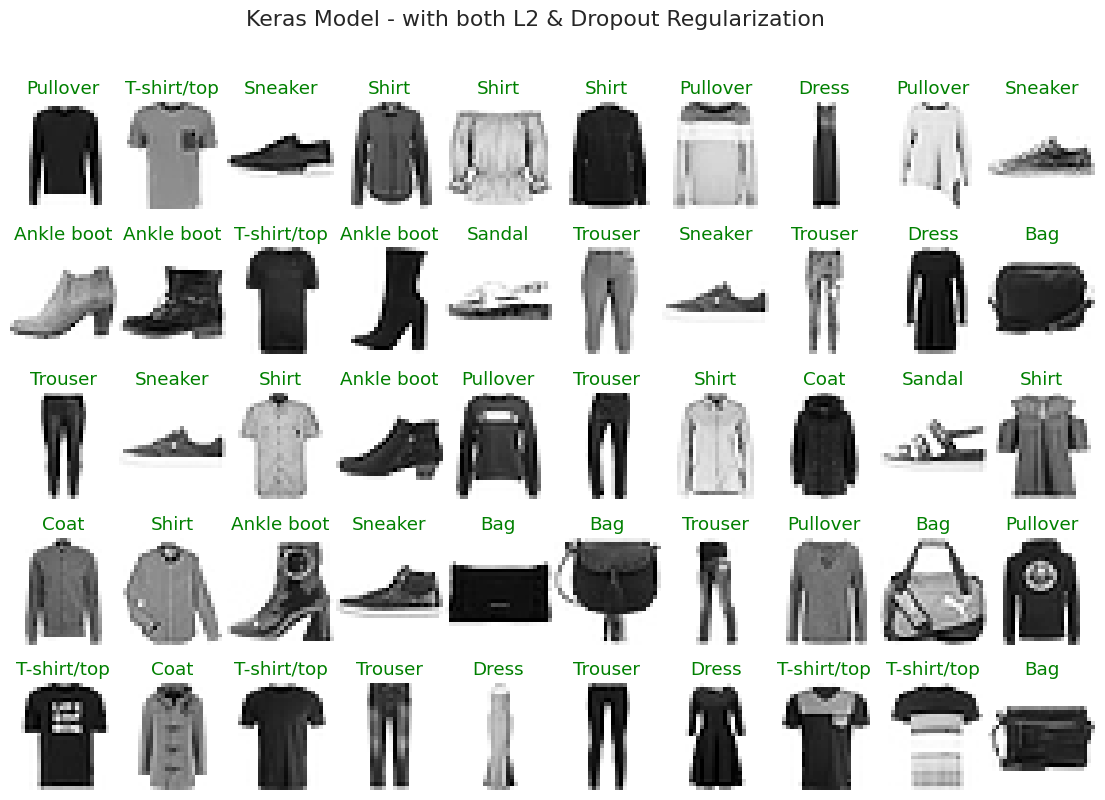

In [ ]:
do_predictions('kr_fashion_cnn_do_l2_reg_2', X_test, y_test, test_images, test_labels,
               plot_title='Keras Model - with both L2 & Dropout Regularization')

**Observations & Conclusion:**<br/>


* **Conclusion:** Using both L2 regularization & Dropout regularization gives worse performance than using just L2 or just dropout regularization.
* Perhaps our combination of L2 regularization & dropout regularization was _too aggressive_ for this model's architecture. We may want to _simplify_ by reducing the values used.


In [ ]:
model = build_model(use_l2_reg=True, use_dropout=True, l2_loss_lambda=0.00020)
print(model.summary())

Using L2 regularization 0.000200


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 activation (Activation)     (None, 28, 28, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0     

Epoch 1/200
1875/1875 [==============================] - 16s 7ms/step - loss: 0.9775 - acc: 0.7867 - val_loss: 0.7175 - val_acc: 0.8569 - lr: 0.0010
Epoch 2/200
1875/1875 [==============================] - 14s 7ms/step - loss: 0.7134 - acc: 0.8537 - val_loss: 0.6438 - val_acc: 0.8750 - lr: 0.0010
Epoch 3/200
1875/1875 [==============================] - 12s 7ms/step - loss: 0.6456 - acc: 0.8708 - val_loss: 0.5787 - val_acc: 0.8916 - lr: 0.0010
Epoch 4/200
1875/1875 [==============================] - 12s 6ms/step - loss: 0.6277 - acc: 0.8780 - val_loss: 0.5987 - val_acc: 0.8885 - lr: 0.0010
Epoch 5/200
1875/1875 [==============================] - 12s 6ms/step - loss: 0.6133 - acc: 0.8816 - val_loss: 0.5484 - val_acc: 0.9032 - lr: 0.0010
Epoch 6/200
1875/1875 [==============================] - 12s 6ms/step - loss: 0.5831 - acc: 0.8876 - val_loss: 0.5261 - val_acc: 0.9016 - lr: 0.0010
Epoch 7/200
1875/1875 [==============================] - 12s 7ms/step - loss: 0.5656 - acc: 0.8910 - val_l

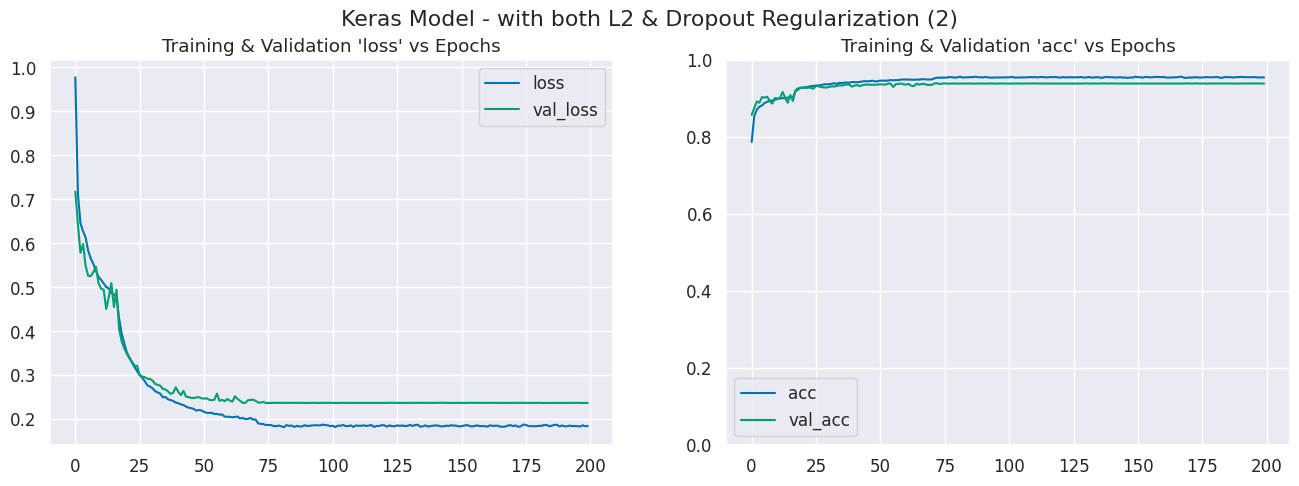


Evaluating...
Training data:
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1252 - acc: 0.9787
  Training : loss 0.125 - acc 0.979
Cross-validation data:
250/250 [==============================] - 1s 3ms/step - loss: 0.2371 - acc: 0.9385
  Cross-val: loss 0.237 - acc 0.938
Saved model to file /content/drive/My Drive/Colab Notebooks/model_states/kr_fashion_cnn_do_l2_reg_2_2.h5


In [ ]:
model_name = 'kr_fashion_cnn_do_l2_reg_2_2'
plot_title = plot_title='Keras Model - with both L2 & Dropout Regularization (2)'
train_and_evaluate_model(model, X_train, y_train, X_val, y_val,
                         num_epochs=200, batch_size=32, callbacks=callbacks_list2,
                         plot_title=plot_title, model_save_name=model_name)
del model

Loaded Keras model from /content/drive/My Drive/Colab Notebooks/model_states/kr_fashion_cnn_do_l2_reg_2_2.h5
Evaluating against test data...
63/63 [==============================] - 1s 4ms/step - loss: 0.2450 - accuracy: 0.9400
  - Test data: loss 0.245 - acc 0.940
Displaying sample predictions...
63/63 [==============================] - 0s 2ms/step


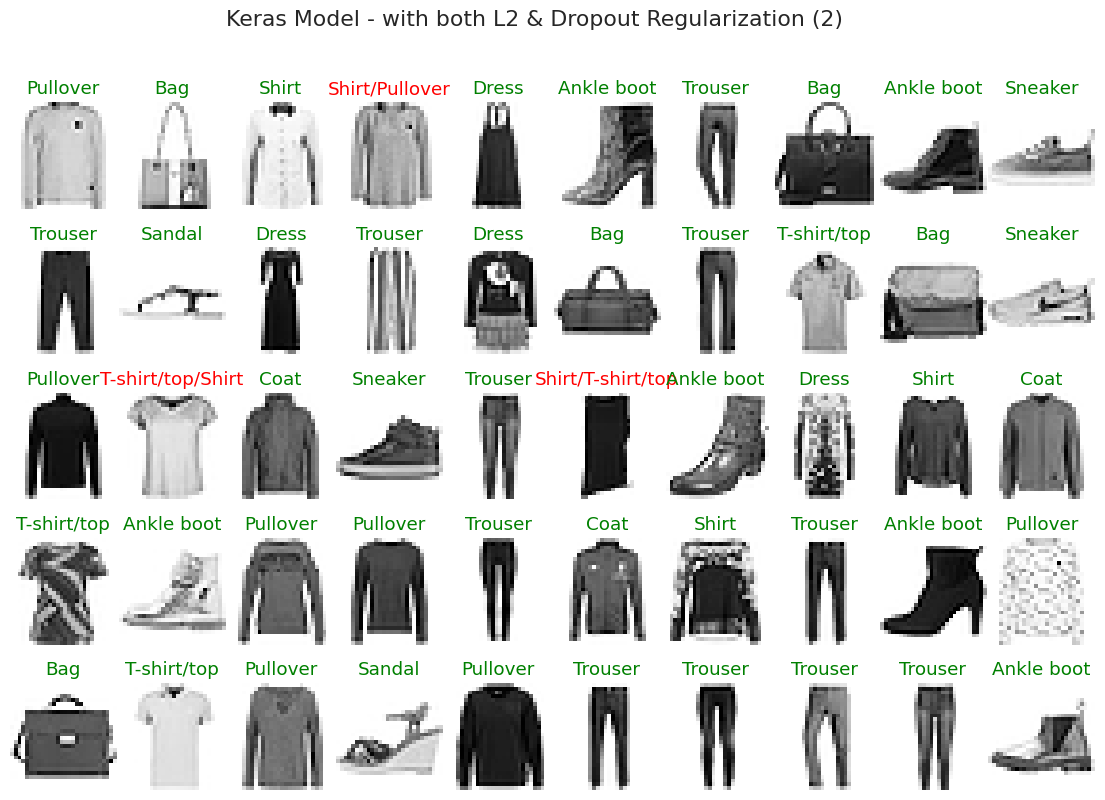

In [ ]:
do_predictions('kr_fashion_cnn_do_l2_reg_2_2', X_test, y_test, test_images, test_labels,
               plot_title='Keras Model - with both L2 & Dropout Regularization (2)')

**Observations & Conclusion:**<br/>


* **Conclusion:** Using a smaller `l2_loss_lambda` is improving the performance of the model. However, note that performance seems to be tending towards the performance we get by using just Dropout Regularization!
* So, I finally conclude that with this model architecture, I get best performance using just Dropout Regularization - changing model architecture may give different performance metrics.



In [ ]:
model = build_model(use_dropout=True)
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 activation (Activation)     (None, 28, 28, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0     